# End-to-end notebook: fisher sampling graphs


In [1]:
# install dependencies

! pip install -q joblib  # joblib for memoizing functions
! pip install -q ipywidgets widgetsnbextension pandas-profiling # IProgress for progress bars

In [2]:
# Add model_merging to the python path

import os
import sys

model_merging_base = os.path.abspath("../model_merging/")
# assert it exist
assert os.path.exists(model_merging_base)
if model_merging_base not in sys.path:
    sys.path.append(model_merging_base)

In [3]:
# import joblib for caching and distributed computing
from math import sqrt

from joblib import Memory, Parallel, delayed

# memory = Memory(location="cache", verbose=10)
memory = Memory(location="cache", verbose=0)

parallel = Parallel(n_jobs=2, return_as="generator")
output_generator = parallel(delayed(sqrt)(i**2) for i in range(10))

In [4]:
# Imports and cached functions

import os

from llm_weaver import (
    calculate_score_from_weaving_config,
    get_score_from_named_model,
    test_weaver,
)

# Disable parallelism in tokenizers to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

calculate_score_from_weaving_config_cached = memory.cache(
    calculate_score_from_weaving_config
)
test_weaver_cached = memory.cache(test_weaver)

get_score_from_named_model_cached = memory.cache(get_score_from_named_model)

## Define weave config generator


In [6]:
import numpy as np
from llm_weaver import dict_overwrite, get_model_config

from model_merging import hdf5_util, sample_layers


def sample_weave_configs_fisher_sampling_iter(
    alpha_blend,
    beta_choice,
    loc_spread,
    output_length,
    models,
    blank_model_template_model_id,
    max_configs=1,
):
    fishers = [
        hdf5_util.load_variables_from_hdf5(fisherpath, trainable=False)
        for fisherpath in [model["fishers_path"] for model in models]
    ]
    blank_model_config = dict_overwrite(
        get_model_config(blank_model_template_model_id),
        {
            "num_hidden_layers": output_length,
        },
    )
    # Bring the random seed outside the loop for reproducibility
    rng = np.random.default_rng(seed=42)
    for _ in range(max_configs):
        layer_config = list(
            sample_layers.generate_layer_config(
                fishers,
                dict(
                    alpha_blend=alpha_blend,
                    beta_choice=beta_choice,
                    loc_spread=loc_spread,
                    output_length=output_length,
                ),
                minus_one=False,
                rng=rng,
            )["layers"]
        )
        # print(layer_config)

        config = {
            "glue_task": "rte",
            "tokenizer_model_id": blank_model_template_model_id,
            # The task (i.e. the classification head output size should match the task at hand)
            "blank_model_config": blank_model_config,
            # Layer assignments
            "layer_assignments": [
                {
                    "type": "SingleLayer",
                    "params": {
                        "donor": models[int(model_n_layer_m.split("_")[1])][
                            "model_id"
                        ],  # the n in model_n_layer_m
                        # Pick a layer
                        "hidden_layer_number": int(
                            model_n_layer_m.split("_")[-1]
                        ),  # the m in model_n_layer_m
                    },
                }
                for model_n_layer_m in layer_config
            ],
            # The head (i.e. the classification head should match the task at hand)
            # THESE ARE DIFFERENT BETWEEN RTE AND MNLI
            "classification_head": {
                "type": "SingleClassificationHead",
                "params": {
                    "donor": blank_model_template_model_id,
                },
            },
            # The embeddings layer
            # THESE ARE DIFFERENT BETWEEN RTE AND MNLI
            "embeddings": {
                "type": "SingleEmbeddings",
                "params": {
                    "donor": blank_model_template_model_id,
                },
            },
        }
        yield config
        # yield generate_layer_config(fishers, sample_config)
    # # Need to decide what to do about embeddings and classification head.


# sample_layers.generate_fisher_distributions(fishers)


list(
    sample_weave_configs_fisher_sampling_iter(
        **{
            "alpha_blend": 1,  # fisher weight vs location weight
            "beta_choice": 1,  # which model to choose from
            "loc_spread": 0.01,  # spread of location weight
            "output_length": 24,
            "models": [
                {
                    "model_id": "textattack/roberta-base-RTE",
                    "fishers_path": "../data/fisher_info/rte_fisher.h5",
                },
                {
                    "model_id": "textattack/roberta-base-MNLI",
                    "fishers_path": "../data/fisher_info/mnli_fisher.h5",
                },
            ],
            "blank_model_template_model_id": "textattack/roberta-base-RTE",
        },
        max_configs=1,
    )
)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[{'glue_task': 'rte',
  'tokenizer_model_id': 'textattack/roberta-base-RTE',
  'blank_model_config': {'return_dict': True,
   'output_hidden_states': False,
   'output_attentions': False,
   'torchscript': False,
   'torch_dtype': None,
   'use_bfloat16': False,
   'tf_legacy_loss': False,
   'pruned_heads': {},
   'tie_word_embeddings': True,
   'is_encoder_decoder': False,
   'is_decoder': False,
   'cross_attention_hidden_size': None,
   'add_cross_attention': False,
   'tie_encoder_decoder': False,
   'max_length': 20,
   'min_length': 0,
   'do_sample': False,
   'early_stopping': False,
   'num_beams': 1,
   'num_beam_groups': 1,
   'diversity_penalty': 0.0,
   'temperature': 1.0,
   'top_k': 50,
   'top_p': 1.0,
   'typical_p': 1.0,
   'repetition_penalty': 1.0,
   'length_penalty': 1.0,
   'no_repeat_ngram_size': 0,
   'encoder_no_repeat_ngram_size': 0,
   'bad_words_ids': None,
   'num_return_sequences': 1,
   'chunk_size_feed_forward': 0,
   'output_scores': False,
   'return

## Graph single run which should be identical to textAttack/roberta-base-RTE

In [10]:
def sample_config_to_plots(sample_config, n_examples=128, split="validation", n_jobs=5):
    weave_configs = list(
        sample_weave_configs_fisher_sampling_iter(**sample_config),
    )

    scores = Parallel(n_jobs=n_jobs, return_as="list")(
        delayed(calculate_score_from_weaving_config_cached)(
            weave_config,
            n_examples=n_examples,
            split=split,
        )
        for weave_config in weave_configs
    )
    accuracies = [score["accuracy"] for score in scores]

    # title = f"Accuracy distribution on task {weave_configs[0]['glue_task']} with a={sample_config['alpha_blend']}, b={sample_config['beta_choice']}, sig={sample_config['loc_spread']}, layers={sample_config['output_length']}"

    # # create figure and ax
    # fig, ax = plt.subplots()
    # ax.hist(accuracies, bins=10)
    # ax.set_title(title)
    # plt.show()

    return accuracies, weave_configs


accuracies, weave_configs = sample_config_to_plots(
    {
        "alpha_blend": 1,  # fisher weight vs location weight
        "beta_choice": 1,  # which model to choose from
        "loc_spread": 0.01,  # spread of location weight
        "output_length": 12,
        "models": [
            {
                "model_id": "textattack/roberta-base-RTE",
                "fishers_path": "../data/fisher_info/rte_fisher.h5",
            },
            {
                "model_id": "textattack/roberta-base-MNLI",
                "fishers_path": "../data/fisher_info/mnli_fisher.h5",
            },
        ],
        "blank_model_template_model_id": "textattack/roberta-base-RTE",
        "max_configs": 5,
    },
)
accuracies

[0.7265625, 0.7265625, 0.7265625, 0.7265625, 0.7265625]

## Graph many examples

AttributeError: QuadMesh.set() got an unexpected keyword argument 'title'

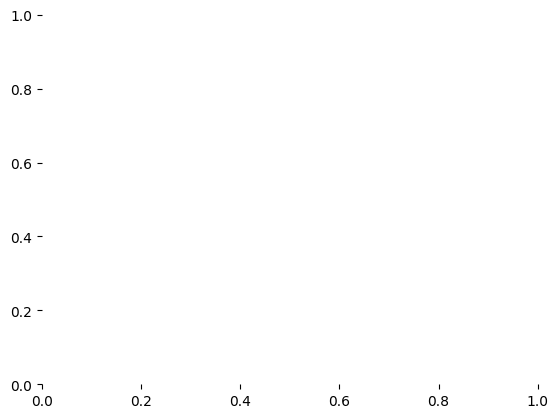

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(records)

# plot heatmap with alpha and beta
import seaborn as sns

loc_spread = 0.01

ax = plt.axes()
sns.heatmap(data, ax=ax)

ax.set_title("lalala")
sns.heatmap(
    df.pivot(index="alpha", columns="beta", values="accuracy"),
    annot=True,
    # title
    title=f"Accuracy distribution on RTE with sig={loc_spread}",
)

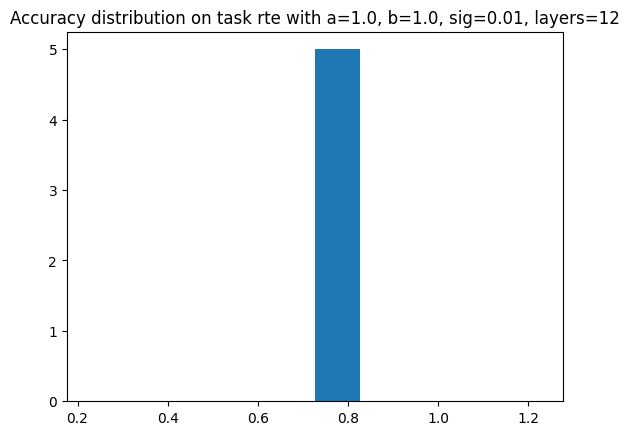

calculating score for weaving config md5sum: 07664b9d30c6be390b13b8880b734d49
calculating score for weaving config md5sum: 8e1bf19259f2f804c9859c90619ba71e
calculating score for weaving config md5sum: 754606b4cb48f3fcaded9d5a1424d713
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-MNLI


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can 

Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can 

calculating score for weaving config md5sum: b32db7899a3d930468914c39a32a564d
Loading textattack/roberta-base-RTE


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Loading textattack/roberta-base-MNLI


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/model_merging/model_merging/evaluation.py:7: FutureWarning: load_metric is deprecated and will be

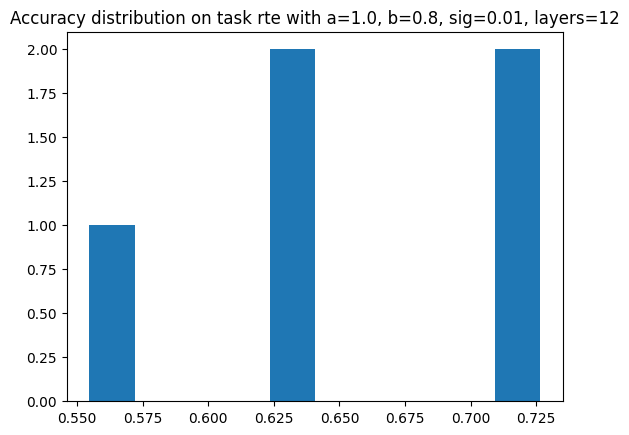

calculating score for weaving config md5sum: 5b1db508dc4e17d353a99e026701e14b
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


calculating score for weaving config md5sum: 98ee10487f0828dc7667e0c8e267c32b
calculating score for weaving config md5sum: 787328164789fed79310220e42ee2638
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE


2023-12-12 18:10:02.241882: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to 

Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-MNLI


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a lo

calculating score for weaving config md5sum: ae22897e7d7126979a4d0779bc11e68d
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:10:14.601277: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:10:15.760582: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

calculating score for weaving config md5sum: da296edfa661585a7473eb46678fb2a4
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:10:28.294186: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


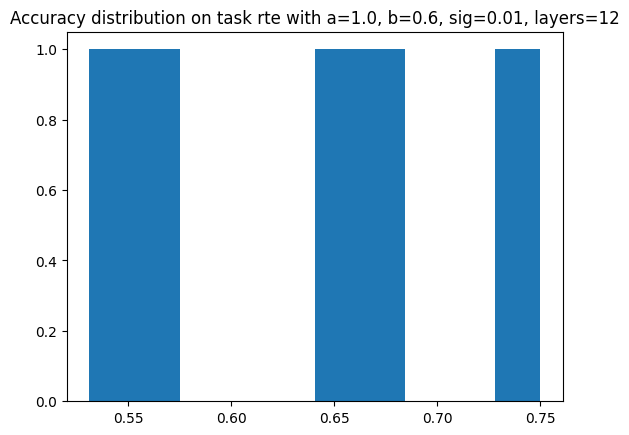

calculating score for weaving config md5sum: e24af0cc14f0d95beed29d7a063cd396
calculating score for weaving config md5sum: 766f916fb15a67318be848b523040301
calculating score for weaving config md5sum: 4a37819b1ffeab6e23acee7f1ba9b557
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:10:42.595887: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:10:43.836409: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:10:44.038026: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: bcb378d389c60b62161019d822aff597
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: c172087cdc78218291390f590b67eb26


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:10:57.613511: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:10:59.845294: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

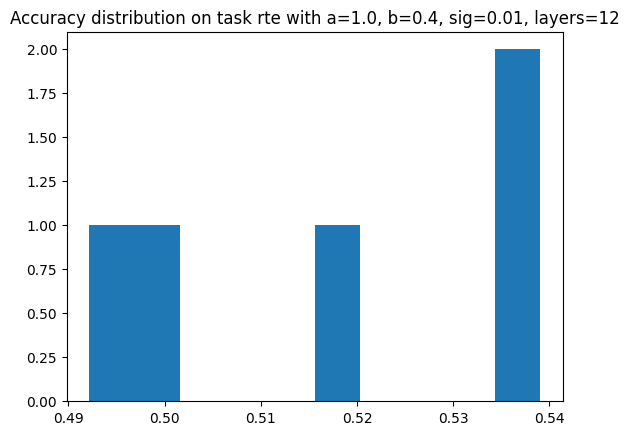

calculating score for weaving config md5sum: 62b8e91675c7933591f5e9d9817f6f37
calculating score for weaving config md5sum: 639ced682bb415bb5a206f2917db1afa
calculating score for weaving config md5sum: 6c4c407d12cfe0d641be641508aa7404
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: 5a2cd2db0fb984563a2b08c763bfaa4e
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:11:29.418491: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


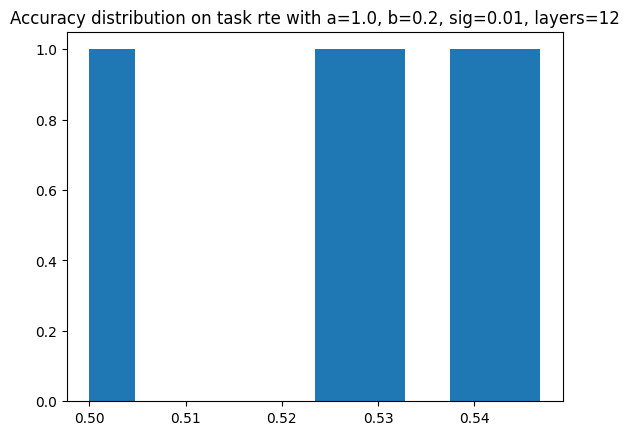

calculating score for weaving config md5sum: e2f88325eabe5315e0be97940c5a7cae
calculating score for weaving config md5sum: e2f88325eabe5315e0be97940c5a7cae
calculating score for weaving config md5sum: e2f88325eabe5315e0be97940c5a7cae
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

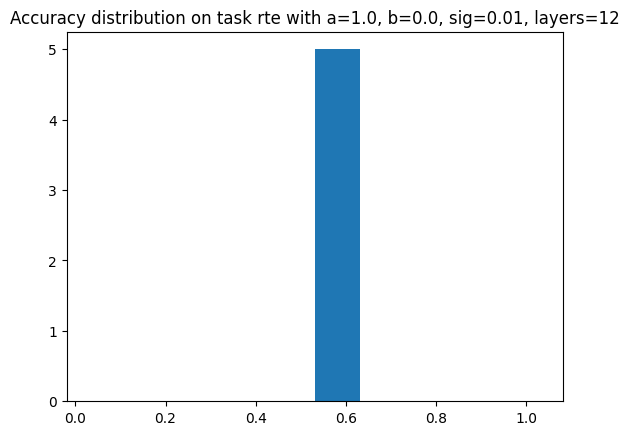

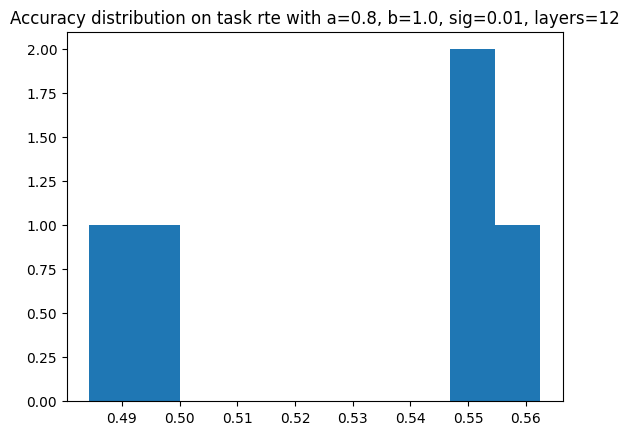

calculating score for weaving config md5sum: bfea4c0d10849ad164d76feb64ff2de3
calculating score for weaving config md5sum: 40b69093f2464cdc5b03e4fbda4eda3c
calculating score for weaving config md5sum: 6ecc835a16c081cc21d96f13c9e0faec
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:12:04.800672: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:12:05.837076: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:12:05.965506: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: 471030e854ccf6486f2eaa6c058dd9bc
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:12:18.461580: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


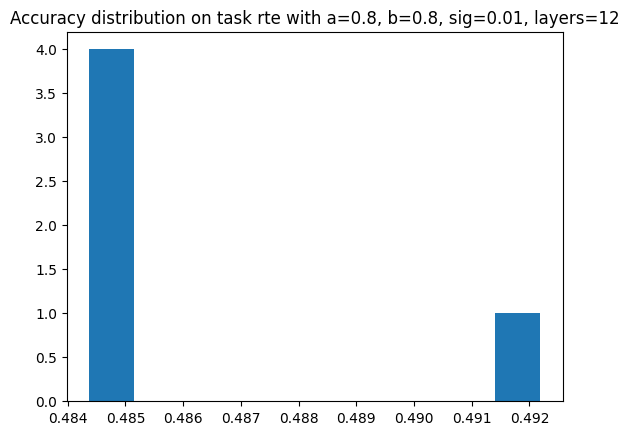

calculating score for weaving config md5sum: 2f327d64ea9c59a8c310e5b263ba7f69
calculating score for weaving config md5sum: 640b709426cdf593e71167d5a5ef4bba
calculating score for weaving config md5sum: c1facca1fec20f1f3ecb92601e4bb525
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:12:33.776534: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:12:34.959425: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:12:34.987269: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: 9b0ee143d5bf2bb4636c0474777eabf9
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:12:47.691395: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


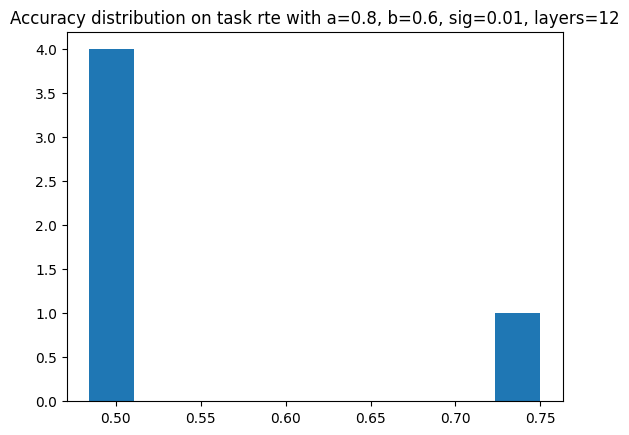

calculating score for weaving config md5sum: 12aa8e7a3b5f6156a822b7b899e42a65
calculating score for weaving config md5sum: 516c0984aebebc8b0cffbef10a82e6c8
calculating score for weaving config md5sum: 6b0fb8f9b333faed4a617e5c427bfebd
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:13:02.192908: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-12-12 18:13:03.676057: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:13:04.197783: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


calculating score for weaving config md5sum: 66da140646aab37695b08169193e61f2
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:13:16.057998: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


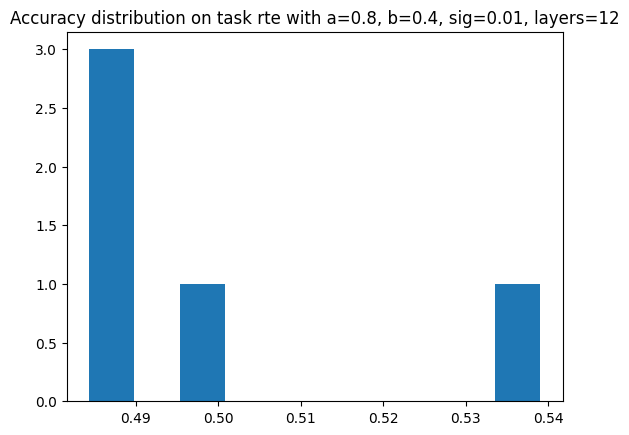

calculating score for weaving config md5sum: 513623040728875bd1da1519e95846a1
calculating score for weaving config md5sum: 1accdea6dede90beebe36cecaf1a2d89
calculating score for weaving config md5sum: 3ea9acc7f3c68b8cc3f92c3e64979978
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:13:30.960641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:13:31.989057: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:13:32.114371: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

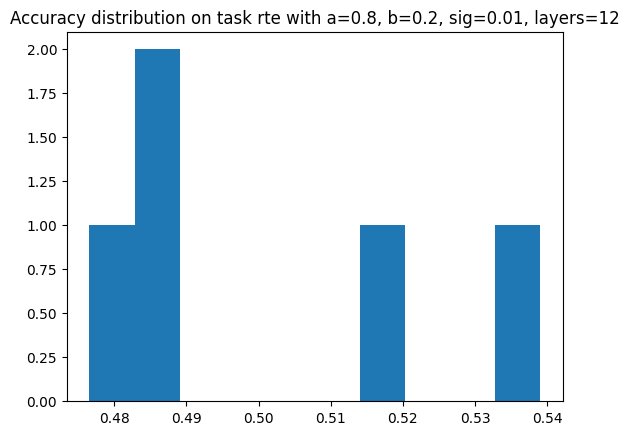

calculating score for weaving config md5sum: 699e4d7fa2bddfc846872bf12c740398
calculating score for weaving config md5sum: 080d6c74a0b7c83cd522251807aab855
calculating score for weaving config md5sum: 5126b52e0bdab02ec7a352aad3571811
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:13:51.125439: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-12-12 18:13:52.195559: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:13:52.442762: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


calculating score for weaving config md5sum: bec1f80249adf6c4ba0e8778ffeae037
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: 0586836c663cdcfcb606fa46b94ea89e
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:14:06.669559: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-12-12 18:14:08.597142: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


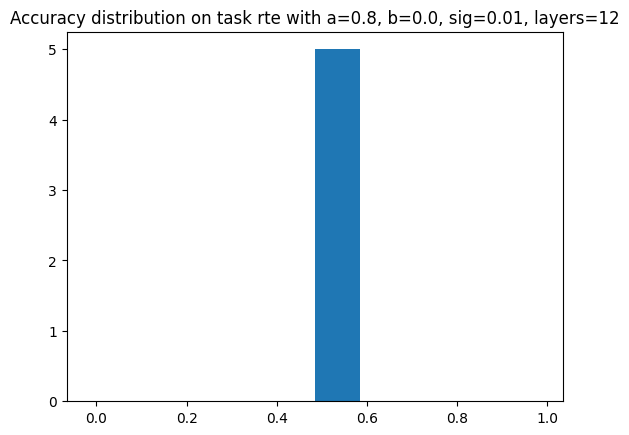

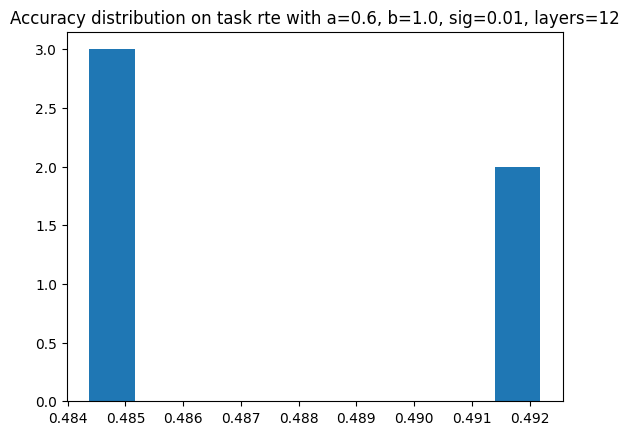

calculating score for weaving config md5sum: d99dc2fb7eda4dae480006a0a9c4a327
calculating score for weaving config md5sum: 4d7e7f1bbe01aa5ab7fd7254fd5f80a4
calculating score for weaving config md5sum: 953902dc5f5271564f891cc82f901ec8
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:14:25.780655: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-12-12 18:14:26.803301: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:14:27.064772: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


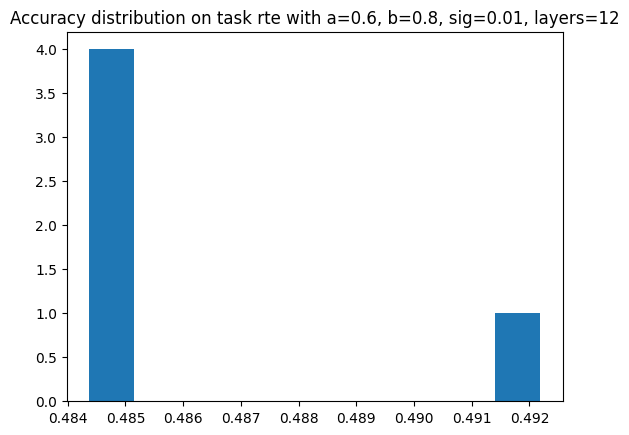

calculating score for weaving config md5sum: 09e0a5a6bfd723c632fc265c62cd870a
calculating score for weaving config md5sum: f266af8d22678570f08b35f96906b168
calculating score for weaving config md5sum: b3aa0e8ecdcd4b51ab0906ccc36386b4
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:14:46.742180: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:14:47.173903: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


calculating score for weaving config md5sum: cdad0a302a483160e35654117091de03
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:14:59.386403: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


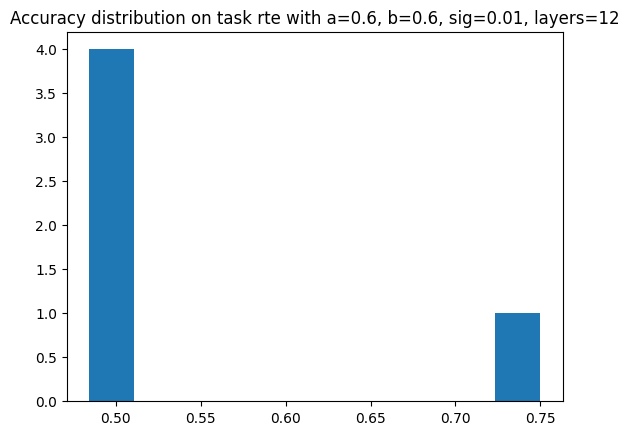

calculating score for weaving config md5sum: a3e53c7b80fa5963f16e6cbebe6db48e
calculating score for weaving config md5sum: 5c1aeca86d4d80d419eb759289da5bd8
calculating score for weaving config md5sum: ebfaf58e93a00b1955b9b38d95099f43
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:15:14.313784: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:15:15.362912: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:15:15.379538: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: 55ac76285b1cc375658f90ef17fa39e3
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: af979952f7a4d5bd7a7d016d7943b91a
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:15:29.57

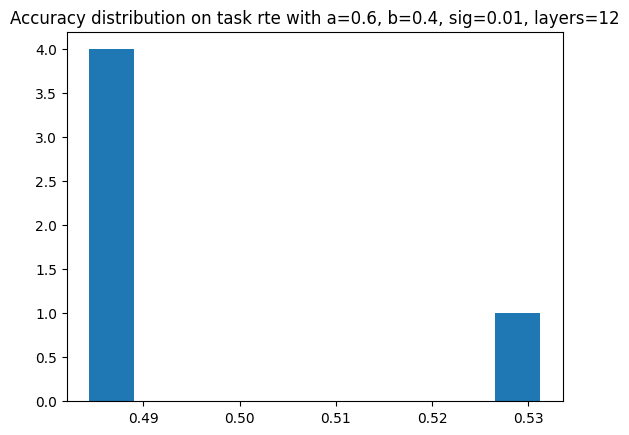

calculating score for weaving config md5sum: 75430a3f4e621ce93eef7ad7f8203b7d
calculating score for weaving config md5sum: 074fb18c000248c1f8ad875a230f7e78
calculating score for weaving config md5sum: 869a53e698babc64ce1ca3e354714624
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:15:49.126614: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:15:49.422818: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


calculating score for weaving config md5sum: 4526d0436210523a991658773e4119e4
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:16:02.105000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


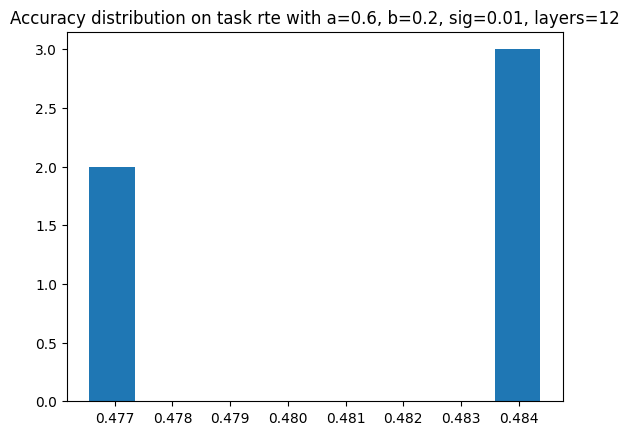

calculating score for weaving config md5sum: e3746dded2998d10a37db408df43eb01
calculating score for weaving config md5sum: b4552ffe260924754d84c93567413131
calculating score for weaving config md5sum: f808942ae27662c2a812b511b407b486
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:16:17.311065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-12-12 18:16:18.545831: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:16:18.644283: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


calculating score for weaving config md5sum: 46c46e31d32164729037b938faee3329
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: 90f0c7575a5de84921f26833d6156039
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:16:33.262899: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-12-12 18:16:35.328939: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


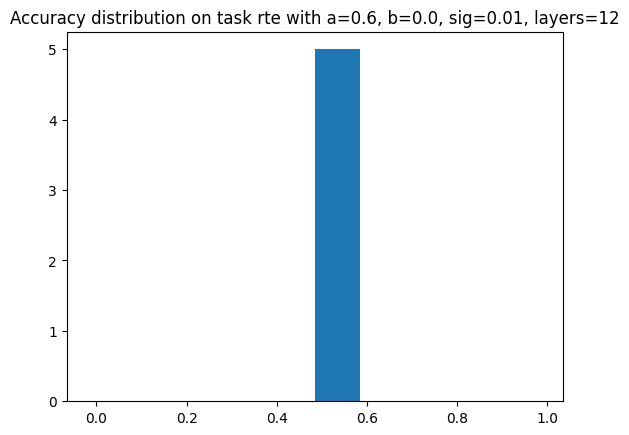

calculating score for weaving config md5sum: bd7d0b564ef5f8f918e556a8ba0430f9
calculating score for weaving config md5sum: 5a2b5448f0d179d0cb664ad7f01bf3d7
calculating score for weaving config md5sum: 049df395a2794c6588a65ad954e548e0
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: 224266653302a0c22bdfcbb52696ff8f
Loading textattack/roberta-base-RTE
calculating score for weaving config md5sum: 09cfae1f58880ae79cf6b39eca4b5780
Loading textattack/roberta-base-RTE


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:17:07.375959: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-12-12 18:17:09.582159: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


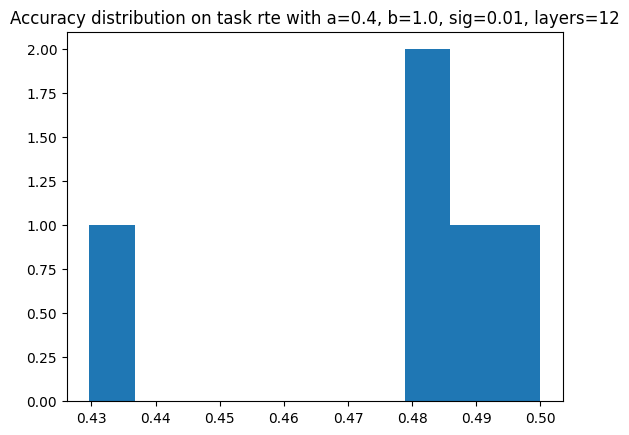

calculating score for weaving config md5sum: f2f6c3149c0d4f35dfc9c391077b16fd
calculating score for weaving config md5sum: decb973e3cce250e85933f92eb253377
calculating score for weaving config md5sum: db14481528dc3b8687a1ecda7a917707
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:17:25.754284: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:17:26.791685: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:17:27.005349: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: 14d62c62efd62ebda2da731a107ac74d
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:17:39.135904: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


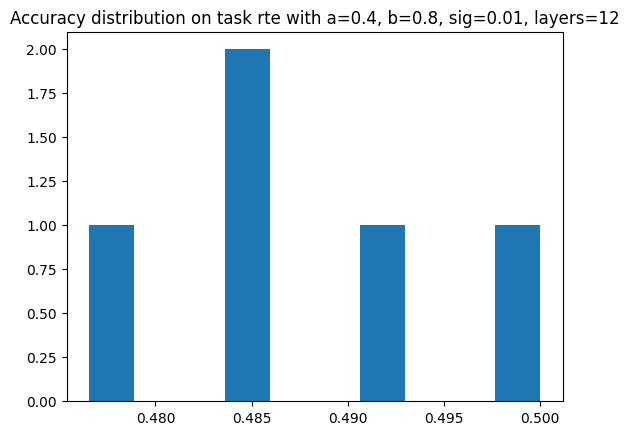

calculating score for weaving config md5sum: 9737ff507bbf06ace842fc43cfd19b4a
calculating score for weaving config md5sum: 0c03f97ede82398d7e5a9d790924a80e
calculating score for weaving config md5sum: e3a3a64c8d21616f94b0e0bfe1cb0bc1
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:17:53.678855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:17:54.847871: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:17:54.992939: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: c58c812bc0f16870c56dee91c139527d
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: 5dc6357b984b7a2eef715593b52359ee


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:18:08.828114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:18:11.156127: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


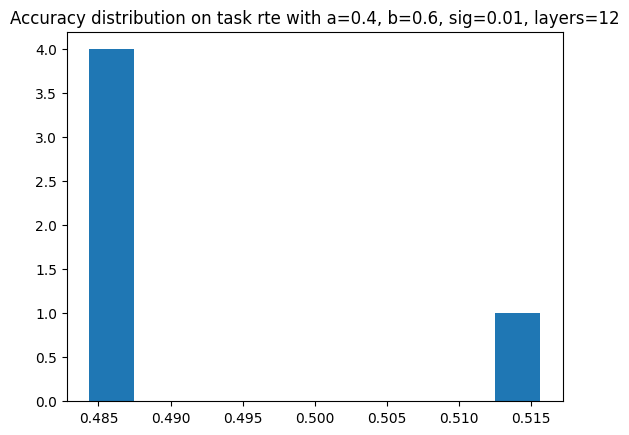

calculating score for weaving config md5sum: 5e6ae179f5cfb09bc39a000770d6f4e8
calculating score for weaving config md5sum: 019b2ac989cb33b2c28df212960644f2
calculating score for weaving config md5sum: 11c1fd1288b0393f1abae2af05dd4386
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:18:26.876403: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:18:27.906136: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:18:27.911119: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: 5c485fa98698b49e3f9f3d3aa6a29d1d
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: 2faf585b6724619c828fa61a42830c80
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:18:41.41

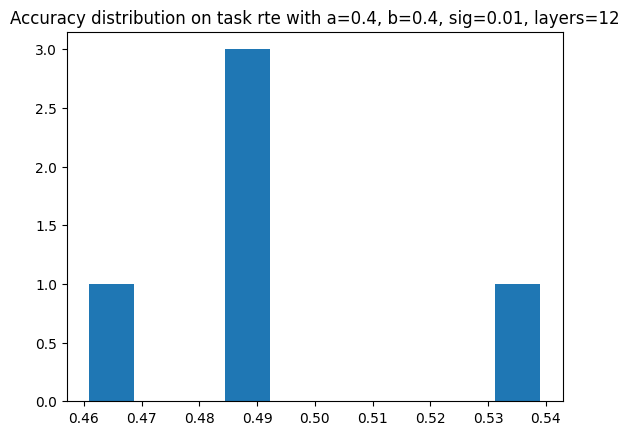

calculating score for weaving config md5sum: e63f9988f043457ba7774e0f0064171f
calculating score for weaving config md5sum: 01bda22d9a036935e4dad1c4a39f46f1
calculating score for weaving config md5sum: 465a473ebd17e3f4be22c42e33b0a4d7
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:19:01.586934: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:19:01.600050: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


calculating score for weaving config md5sum: 76975d49333cde73df3f07b92bae2be4
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:19:14.320513: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


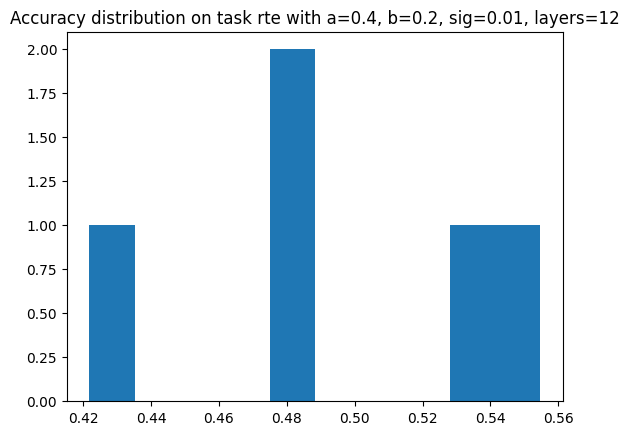

calculating score for weaving config md5sum: 2b5c0905c2828450ec4ca1eeee33f378
calculating score for weaving config md5sum: 0e659c393e29ac59687608a90f73030f
calculating score for weaving config md5sum: 11dc5a91715796d6f86049249992ef39
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:19:28.901207: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:19:29.957432: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:19:30.770481: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: 463bfe634f99ee7a0b32228ca565aae1
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: cfe9fc6b8e396fa0a509814dba3bdf17
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:19:44.63

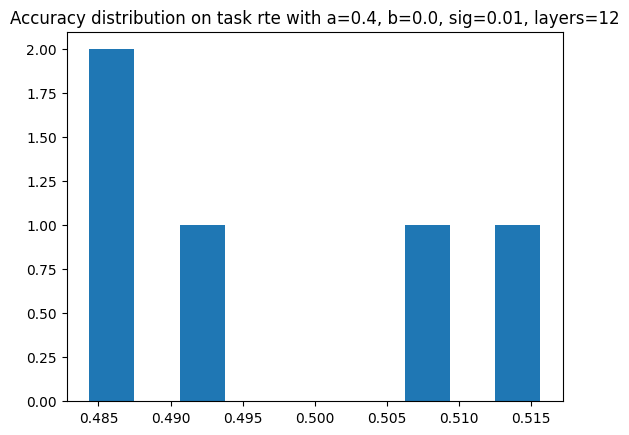

calculating score for weaving config md5sum: 66c0d94e20ccf9f1f8170fee8e573a0b
calculating score for weaving config md5sum: 472d666b3c434e808be7a724a7557db0
calculating score for weaving config md5sum: d45ba4efd9bb0f5a73edb44c859f4276
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: f329856d77bd639202e6a3eecaaffe77
calculating score for weaving config md5sum: a61cf8e1b44d6f0e0e8a533811069619
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:20:17.81

2023-12-12 18:20:20.002436: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


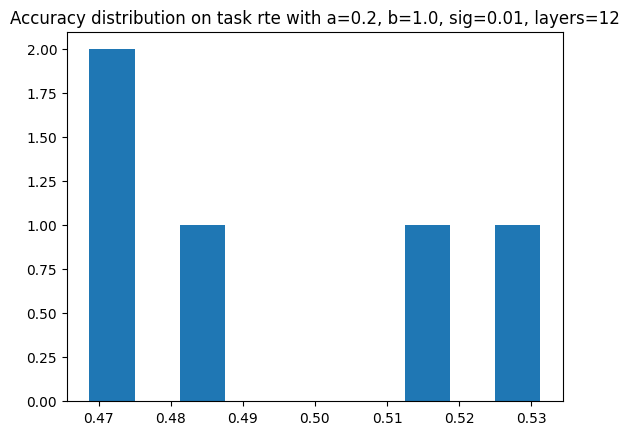

calculating score for weaving config md5sum: 307162692bc48b8ee8892860dee5233c
calculating score for weaving config md5sum: a273d7b6ad5d9a8d05c54517d05eff7f
calculating score for weaving config md5sum: 7708f21bdde8e72b890ae6dcdaf0f676
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: ce9dbd1bdde9fae6049a66642251400a
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:20:49.581869: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


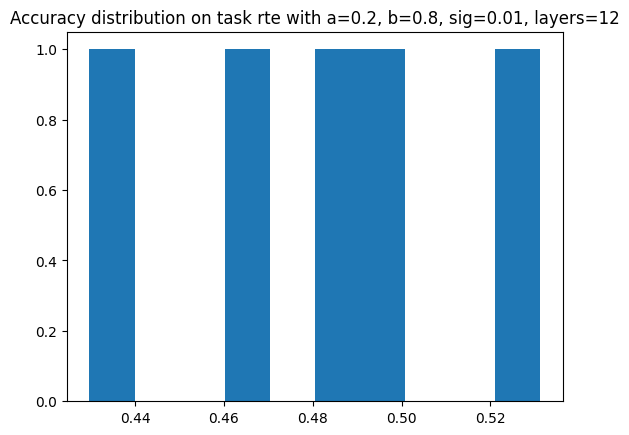

calculating score for weaving config md5sum: 5c23a3e1d8f01e4dd25d2772a9120fa8
calculating score for weaving config md5sum: b5756ff7f1c8192eeedce88778febb3d
calculating score for weaving config md5sum: 88fe93f7516a7f6f2570da12c5ba9b3b
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:21:04.488202: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:21:05.514883: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:21:05.582365: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: 95f35edc9e69c73274e9a63771b58f9b
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: f97bc3a3eaeb81eec88421f9fb8d61d2
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:21:20.21

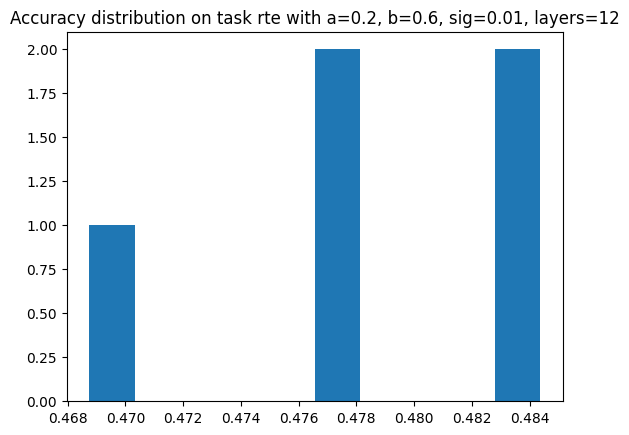

calculating score for weaving config md5sum: 34403c408f89510b544dad21d8c381c7
calculating score for weaving config md5sum: cbb8ac314414de8045042f71b3507b3a
calculating score for weaving config md5sum: e2785bf62125fe543d957efc50161186
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:21:39.214788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:21:39.633297: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


calculating score for weaving config md5sum: 9285e13e6dd6d09e295866cf61eaec97
calculating score for weaving config md5sum: bfaf05c7ff3162b5c82efe5b8b3da38f
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:21:54.60

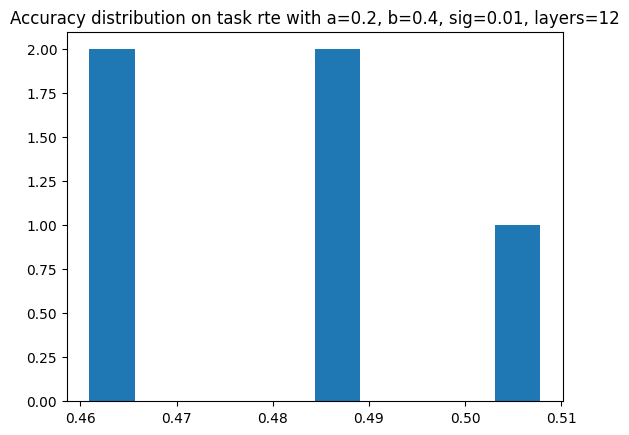

calculating score for weaving config md5sum: 26091b3a6da75af247be13d9b9928a0a
calculating score for weaving config md5sum: d477bc564cf29b2d9b56ece16d5cabf6
calculating score for weaving config md5sum: 809ab92e178780ba89e894da71fd7272
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:22:13.300408: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:22:14.333217: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:22:14.582656: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

calculating score for weaving config md5sum: 82aeddeaf54e00f8545ae032ca63fb51
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:22:27.521676: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


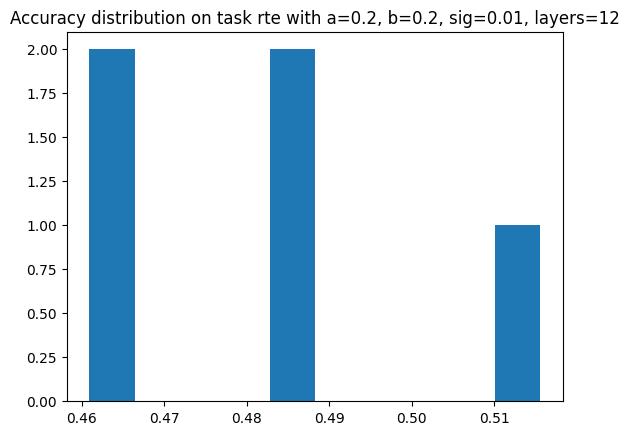

calculating score for weaving config md5sum: 3b43118d1ef68e0f2c739d1e3fab0460
calculating score for weaving config md5sum: b2e294c3acc68fa6fc5c69c52f312859
calculating score for weaving config md5sum: 30dd77b2c82d7b10302de4076e8f5258
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-12-12 18:22:44.335370: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:22:44.344076: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


calculating score for weaving config md5sum: cf47cd5bd7b0e20b2fee620f071ac843
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: a95dbb10d190f89b541c4daf9c0ce336
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:22:59.22

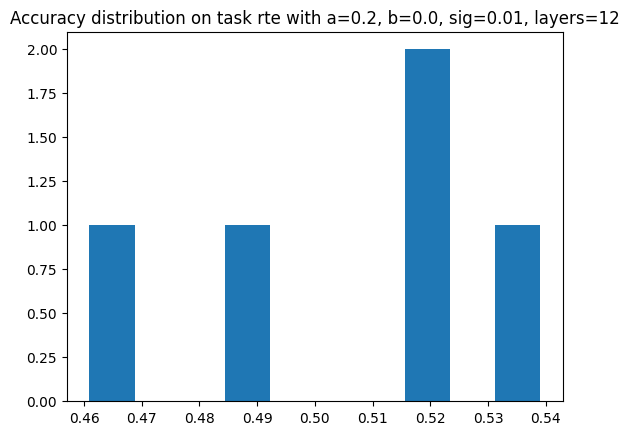

calculating score for weaving config md5sum: 02793d7ea2a9b1d690948af2210a35b3
calculating score for weaving config md5sum: 0a82373a9be41c5e4ce2d0622ffe95b3
calculating score for weaving config md5sum: c767ed27294fa3302a456adeb9bea3be
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: 5f80a28ff65b66db2a7215eb9c0d1e9e
calculating score for weaving config md5sum: db53c3b3f281bb60a12bd2b07e543b2a
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-RTE


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:23:33.90

2023-12-12 18:23:35.703590: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


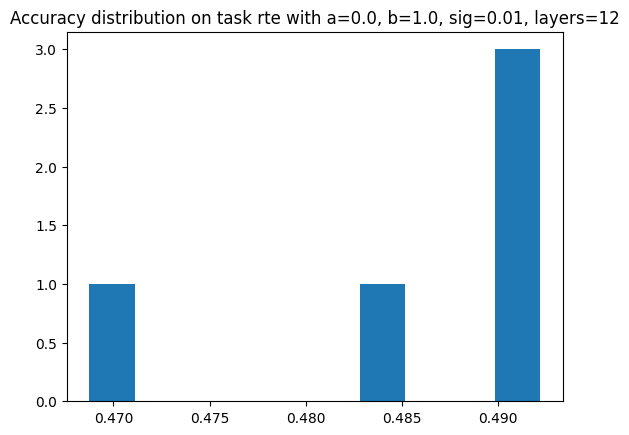

calculating score for weaving config md5sum: 5ef8a8f5027f4b189973bf380ecf743a
calculating score for weaving config md5sum: f6d2acbffd5fd51b640abaaa3c4368d2
calculating score for weaving config md5sum: 8a67bee625e81f18f17db3f48579c7a2
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: a3b1898ddc072d4acfc038b983c95c54
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:24:05.933149: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


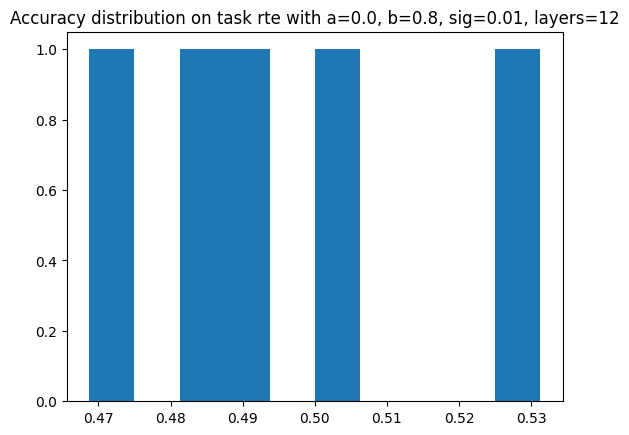

calculating score for weaving config md5sum: c1a44a560601287b4b77d626c1a007c1
calculating score for weaving config md5sum: 5c99571de9ed62e2aa47ea07797d4c5c
calculating score for weaving config md5sum: bb4595c4ef98348a273fd5dba98cd39c
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: 4d8c7e7113e7609319d6e37aed2c952f
calculating score for weaving config md5sum: 8a39bab0355a9bc0341d090484185b39
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:24:37.53

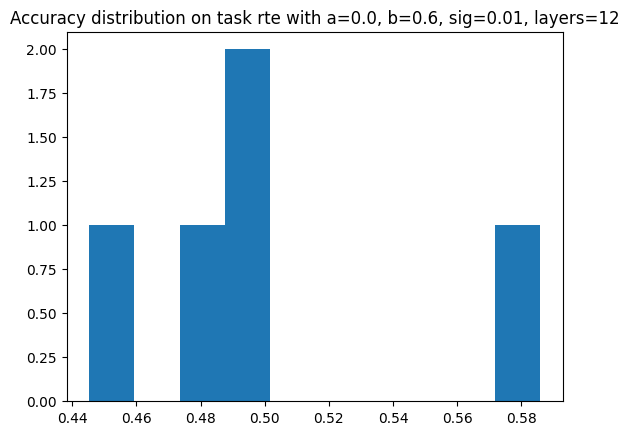

calculating score for weaving config md5sum: 42609599514db86883a0757b863146dc
calculating score for weaving config md5sum: 8da3cb07930781e52193a3c3306a785b
calculating score for weaving config md5sum: 8e978028f8f964bbd12bdf7ee93afff6
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: f3fda61a9b89846418d81ce171e3ef6c
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: 74cd166ab905b5cfacd80bc749fda5cb
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-12-12 18:25:11.530520: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:25:14.046598: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


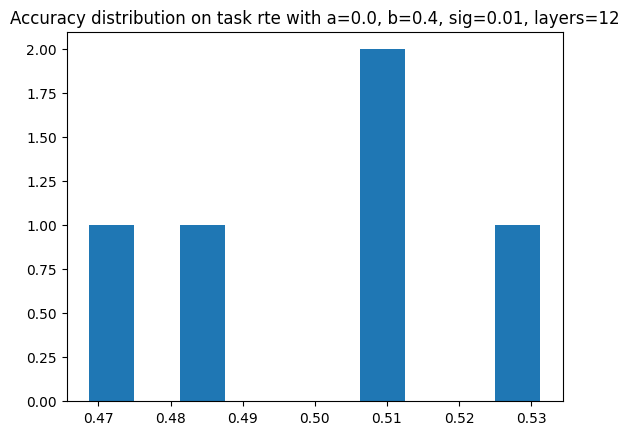

calculating score for weaving config md5sum: af75fb5147ae05e40f473463e9dda77a
calculating score for weaving config md5sum: 9c959d15d0bc163a3bb74eb23356081b
calculating score for weaving config md5sum: 41a066fecfbcef3007386d262061e5ed
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: 8ec791f2d4d1f0b1dfbd3d650f59b9e7
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:25:43.898799: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


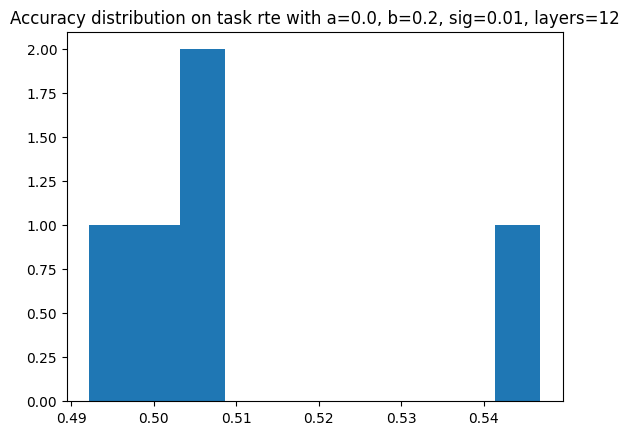

calculating score for weaving config md5sum: 4fc335a46abddc49e78e05001a6df6df
calculating score for weaving config md5sum: 77df010a0720b0b870468b9feeb39208
calculating score for weaving config md5sum: c6b88182fa0e64eee13eede001d43fa8
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

calculating score for weaving config md5sum: b2cf49e4b6b1e4d77670f64be8bb7199
Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI
calculating score for weaving config md5sum: 3415687e8cfe799e33095aed444b4a88


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading textattack/roberta-base-RTE
Loading textattack/roberta-base-MNLI


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-12-12 18:26:14.101618: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-12-12 18:26:16.680235: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

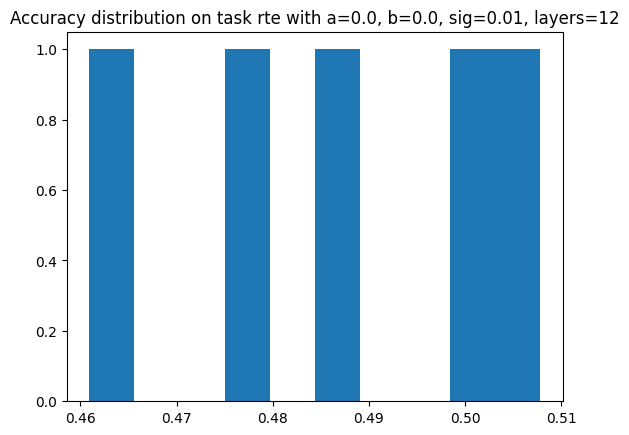

In [8]:
# Make a 6x 1 numpy array
records = []

for alpha in [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]:
    for beta in [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]:
        for loc_spread in [0.01, 0.05, 0.1, 0.4, 1.6]:
            for output_length in [12]:
                # from all locations to part fisher
                accuracies, weave_configs = sample_config_to_plots(
                    {
                        "alpha_blend": alpha,  # fisher weight vs location weight
                        "beta_choice": beta,  # which model to choose from
                        "loc_spread": loc_spread,  # spread of location weight
                        "output_length": output_length,
                        "models": [
                            {
                                "model_id": "textattack/roberta-base-RTE",
                                "fishers_path": "../data/fisher_info/rte_fisher.h5",
                            },
                            {
                                "model_id": "textattack/roberta-base-MNLI",
                                "fishers_path": "../data/fisher_info/mnli_fisher.h5",
                            },
                        ],
                        "blank_model_template_model_id": "textattack/roberta-base-RTE",
                        "max_configs": 5,
                    },
                    n_jobs=3,  # Reduce this if your computer is slowing down too much
                )
                records.append(
                    {
                        "alpha": alpha,
                        "beta": beta,
                        "loc_spread": loc_spread,
                        "output_length": output_length,
                        "accuracies_mean": np.mean(accuracies),
                        "accuracies": accuracies,
                    }
                )

In [15]:
# Inspect the weave configs to make sure they are reasonable
weave_configs

[{'glue_task': 'rte',
  'tokenizer_model_id': 'textattack/roberta-base-RTE',
  'blank_model_config': {'return_dict': True,
   'output_hidden_states': False,
   'output_attentions': False,
   'torchscript': False,
   'torch_dtype': None,
   'use_bfloat16': False,
   'tf_legacy_loss': False,
   'pruned_heads': {},
   'tie_word_embeddings': True,
   'is_encoder_decoder': False,
   'is_decoder': False,
   'cross_attention_hidden_size': None,
   'add_cross_attention': False,
   'tie_encoder_decoder': False,
   'max_length': 20,
   'min_length': 0,
   'do_sample': False,
   'early_stopping': False,
   'num_beams': 1,
   'num_beam_groups': 1,
   'diversity_penalty': 0.0,
   'temperature': 1.0,
   'top_k': 50,
   'top_p': 1.0,
   'typical_p': 1.0,
   'repetition_penalty': 1.0,
   'length_penalty': 1.0,
   'no_repeat_ngram_size': 0,
   'encoder_no_repeat_ngram_size': 0,
   'bad_words_ids': None,
   'num_return_sequences': 1,
   'chunk_size_feed_forward': 0,
   'output_scores': False,
   'return